# Plotter examples

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import plotter

In [3]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [4]:
file = uproot.open("trkana-mc.root")
trkananeg = file["TrkAnaNeg"]["trkana"]

df = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0
df["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                       if index>=0 else 0 
                                       for index, twstart in zip(df["bestcrv"], df["crvinfo__timeWindowStart"])]

samples = {'mc': df}
weights = {'mc': 1}

In [5]:
cuts = [
    "de_status > 0",
    "de_t0 > 700",
    "de_t0 < 1695",
    "deent_td > 0.577350",
    "deent_td < 1.000",
    "deent_d0 < 105",
    "(deent_d0 + 2./deent_om) > 450",
    "(deent_d0 + 2./deent_om) < 680",
    "dequal_TrkQual > 0.5",
    "dequal_TrkPID > 0.95",
    "ue_status <= 0",
    "deent_mom > 95",
    "(bestcrv < 0 | ((-de_t0 + crvinfo__timeWindowStart_best) > 50 | (de_t0-crvinfo__timeWindowStart_best) > 150.0))",
    "is_triggered"
]

cut = " & ".join(cuts)

In [6]:
my_plotter = plotter.Plotter(samples, weights)

## Categorize according to PDG code
Plot categorized according to the PDG code after box cuts.

(0.5, 100000.0)

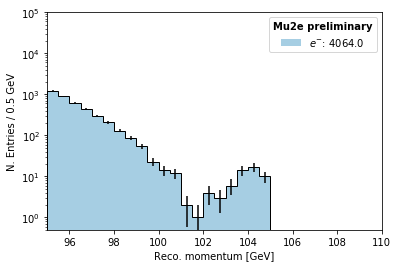

In [7]:
fig, ax = my_plotter.plot_variable("deent_mom",
                                   query=cut,
                                   title="Reco. momentum [GeV]",
                                   cat_var="demcgen_pdg",
                                   x_range=(95,110),
                                   bins=30)
ax.set_yscale('log')
ax.set_ylim(bottom=0.5, top=1e5)

## Categorize according to GenID
Plot categorized according to the GenID code before box cuts.

(0.5, 500000.0)

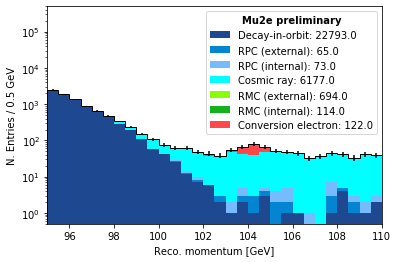

In [8]:
fig, ax = my_plotter.plot_variable("deent_mom",
                                   title="Reco. momentum [GeV]",
                                   cat_var="demcgen_gen",
                                   x_range=(95,110),
                                   bins=30)
ax.set_yscale('log')
ax.set_ylim(bottom=0.5, top=5e5)